# Assignment 3
The objective of this assignment is to get you familiarize with `AutoEncoders`.

## Instructions
- Run this notebook on ```Google Colab(preferable)```
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells. 

## Note
- Code snippets are in ``Pytorch``. If you are comfortable with ``Keras`` feel free to use it. No restrictions on the frameworks

## Datasets 
- CIFAR10

## Packages Used
- Pytorch 
- Refer this link to get familiarity with pytorch and CIFAR10 dataset[link](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment3_Q2.ipynb`.

## Question 2 : Autoencoders


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load CIFAR 10 Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Train Data shape:", trainset.data.shape)
print("Test Data shape:", testset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
Train Data shape: (50000, 32, 32, 3)
Test Data shape: (10000, 32, 32, 3)


### Visualize the Data

torch.Size([16, 3, 32, 32])
torch.Size([16])


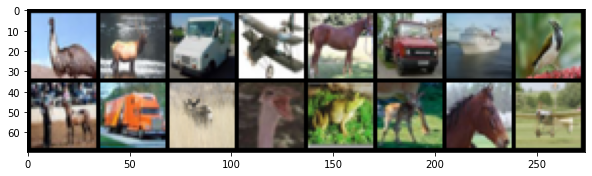

bird  deer  truck plane horse truck ship  bird  horse truck deer  bird  frog  deer  horse plane


In [ ]:
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch_size = 16
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define Model
Refer ``` torch.nn ``` [link](https://pytorch.org/docs/stable/nn.html) 

Experiment with different architectures of encoder and decoder i.e
- encoder and decoder is fully connected layers
- encoder and decoder is combination of convolution layers + fully connected layers
- encoder and decoder is fully convolutional layers.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, ae_type="fully_connected"):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]

        if ae_type == "fully_connected":
          
          self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 32*32),
            nn.ReLU(),
            nn.Linear(32*32, 12*12),
            nn.ReLU(),
            nn.Linear(12*12, 8*8),
            nn.ReLU(),
          )

          self.decoder = nn.Sequential(
              nn.Linear(8*8, 12*12),
              nn.ReLU(),
              nn.Linear(12*12, 32*32),
              nn.ReLU(),
              nn.Linear(32*32, 32*32*3),
              nn.ReLU(),
              nn.Unflatten(1, torch.Size([3, 32, 32])),
              nn.Sigmoid()
          )
        elif ae_type == "convolutional+fully_connected":

          self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*8*8, 16*16),
            nn.ReLU(),
            nn.Linear(16*16, 8*8),
            nn.ReLU(),
          )

          self.decoder = nn.Sequential(
              nn.Linear(8*8, 16*16),
              nn.ReLU(),
              nn.Linear(16*16, 16*8*8),
              nn.ReLU(),
              nn.Unflatten(1 , torch.Size([16, 8, 8])),
              nn.ConvTranspose2d(16, 12, 4, stride=2, padding=1),
              nn.ReLU(),
              nn.ConvTranspose2d(12, 3 , 4 , stride=2 , padding=1),
              nn.Sigmoid()

          )
        
        elif ae_type == "convolutional":
          self.encoder = nn.Sequential(
              # Write your code here
              nn.Conv2d(3, 12, 4, stride=2, padding=1),
              nn.ReLU(),
              nn.Conv2d(12, 16, 4, stride=2, padding=1),
              nn.ReLU(),
              nn.Conv2d(16, 32, 4, stride=2, padding=1),
              nn.ReLU(),
          )
          self.decoder = nn.Sequential(
              # Write your code here
              nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
              nn.Sigmoid(),
              nn.ConvTranspose2d(16, 12, 4, stride=2, padding=1),
              nn.Sigmoid(),
              nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
              nn.Sigmoid(),
          )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


(32 - filter size + 2*padding / stride) + 1-> op image

29 + 2 -> 31/

16 - 4 + 2 / 2

In [ ]:
def print_model(encoder, decoder):
    print("############## Encoder ##############")
    print(encoder)
    print("############## Decoder ##############")
    print(decoder)
    print("")

def create_model(ae_type='fully_connected'):
  autoencoder = Autoencoder(ae_type=ae_type)
  print_model(autoencoder.encoder, autoencoder.decoder)
  return autoencoder

### Training

In [ ]:
from tqdm import tqdm

def train_model(ae_type="fully_connected"):
	# LOSS AND OPTIMIZER
	autoencoder = create_model(ae_type=ae_type)
	criterion = nn.MSELoss()
	optimizer = optim.Adam(autoencoder.parameters())
	autoencoder.to(device)

	for epoch in range(10):
		running_loss = 0.0
		for i, (inputs, _) in enumerate(trainloader, 0):
				inputs = Variable(inputs)
				inputs = inputs.to(device)
				# ============ Forward ============
				encoded, outputs = autoencoder(inputs)
				loss = criterion(outputs, inputs)
				# ============ Backward ============
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
		
				# ============ Logging ============
				running_loss += loss.data
				if i % 2000 == 1999:
					print('[%d, %5d] loss: %.3f' %
						(epoch + 1, i + 1, running_loss / 2000))
					running_loss = 0.0
		
	print('Finished Training')
	print('Saving Model...')
	torch.save(autoencoder.state_dict(), str("autoencoder"+ ae_type + ".pt"))
	
	return autoencoder

### Fully Connected

In [ ]:
autoencoder_fc = train_model(ae_type="fully_connected")

############## Encoder ##############
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=1024, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=144, bias=True)
  (4): ReLU()
  (5): Linear(in_features=144, out_features=64, bias=True)
  (6): ReLU()
)
############## Decoder ##############
Sequential(
  (0): Linear(in_features=64, out_features=144, bias=True)
  (1): ReLU()
  (2): Linear(in_features=144, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=3072, bias=True)
  (5): ReLU()
  (6): Unflatten(dim=1, unflattened_size=torch.Size([3, 32, 32]))
  (7): Sigmoid()
)

[1,  2000] loss: 0.055
[2,  2000] loss: 0.051
[3,  2000] loss: 0.050
[4,  2000] loss: 0.049
[5,  2000] loss: 0.049
[6,  2000] loss: 0.049
[7,  2000] loss: 0.048
[8,  2000] loss: 0.048
[9,  2000] loss: 0.048
[10,  2000] loss: 0.048
Finished Training
Saving Model...


### Convolutional

In [ ]:
autoencoder_con = train_model(ae_type="convolutional")

convolutional
convolutional
############## Encoder ##############
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)
############## Decoder ##############
Sequential(
  (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): Sigmoid()
  (2): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): Sigmoid()
  (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Sigmoid()
)

[1,  2000] loss: 0.019
[2,  2000] loss: 0.011
[3,  2000] loss: 0.006
[4,  2000] loss: 0.005
[5,  2000] loss: 0.004
[6,  2000] loss: 0.004
[7,  2000] loss: 0.004
[8,  2000] loss: 0.004
[9,  2000] loss: 0.003
[10,  2000] loss: 0.003
Finished Training
Saving Model...


### Fully Connected and Convolutional

In [ ]:
autoencoder_fc_con = train_model(ae_type="convolutional+fully_connected")

convolutional+fully_connected
convolutional+fully_connected
############## Encoder ##############
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1024, out_features=256, bias=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=64, bias=True)
  (8): ReLU()
)
############## Decoder ##############
Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1024, bias=True)
  (3): ReLU()
  (4): Unflatten(dim=1, unflattened_size=torch.Size([16, 8, 8]))
  (5): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (8): Sigmoid()
)

[1,  2000] loss: 0.026
[2,  2000] loss: 0.015
[3,  2000] loss: 0.01

### Load the saved model and Reconstruct the image

In [ ]:
autoencoder_fc.load_state_dict(torch.load("/content/autoencoderfully_connected.pt"))
autoencoder_con.load_state_dict(torch.load("/content/autoencoderconvolutional.pt"))
autoencoder_fc_con.load_state_dict(torch.load("/content/autoencoderconvolutional+fully_connected.pt"))

<All keys matched successfully>

#### Provide Qualitative Results and Aanlysis with different encoder and decoder architectures as mentioned above.

GroundTruth:    cat  ship  ship plane  frog


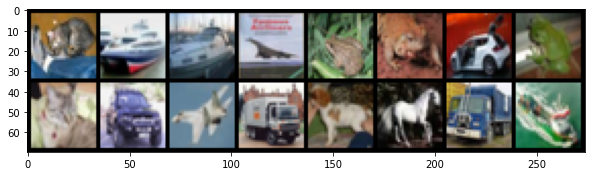

FULLY CONNECTED LAYERS - Reconstructed images
torch.Size([16, 3, 32, 32])


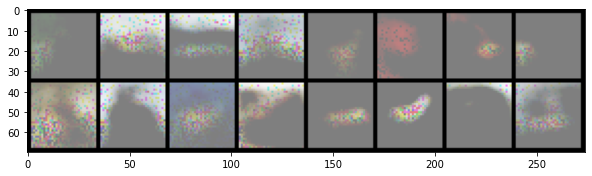

CONVOLUTIONAL LAYERS - Reconstructed images
torch.Size([16, 3, 32, 32])


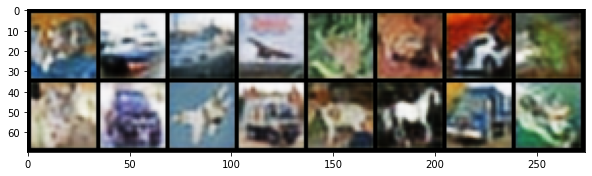

FULLY CONNECTED + CONVOLUTIONAL LAYERS - Reconstructed images
torch.Size([16, 3, 32, 32])


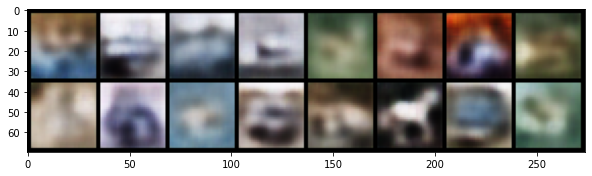

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)
images = images.to(device)

print("FULLY CONNECTED LAYERS - Reconstructed images")
decoded_imgs = autoencoder_fc(images)[1]
decoded_imgs = decoded_imgs.view(decoded_imgs.size(0), 3, 32, 32)
print(decoded_imgs.shape)
imshow(torchvision.utils.make_grid(decoded_imgs.cpu().data))

print("CONVOLUTIONAL LAYERS - Reconstructed images")
decoded_imgs = autoencoder_con(images)[1]
decoded_imgs = decoded_imgs.view(decoded_imgs.size(0), 3, 32, 32)
print(decoded_imgs.shape)
imshow(torchvision.utils.make_grid(decoded_imgs.cpu().data))

print("FULLY CONNECTED + CONVOLUTIONAL LAYERS - Reconstructed images")
decoded_imgs = autoencoder_fc_con(images)[1]
decoded_imgs = decoded_imgs.view(decoded_imgs.size(0), 3, 32, 32)
print(decoded_imgs.shape)
imshow(torchvision.utils.make_grid(decoded_imgs.cpu().data))

#### 2.1 What are the Applications of Autoencoders and different types of Autoencoders

#### Applications:
- Black and White to colour images
- Restoring corrupted or dirty images (Image Denoising)
- Missing Value Imputation
- Dimensionality Reduction

#### Types
- Undercomplete Autoencoders
- Sparse Autoencoders
- Denoising Autoencoders
- Deep Autoencoders


####2.2 PCA versus Autoencoders. Give detailed differences between them. (can use equations in latex and figures for the justification).


- **PCA** - Can only do linear mapping to lower dimensions <br> **AE** - Can learn non linear transformations to lower dimensions due to the activation functions
- **PCA** - PCA features are totally linearly uncorrelated with each other since features are projections onto the orthogonal basis <br> **AE** - Features can be correlated with each other
- **PCA** - Simple Linear mapping <br> **AE** - Prone to overfitting